# Group Analysis

Desired output figure:
- time x classification accuracy
- Within, Pre & Post alignment


Notes
-------
- Best performance (non-time resolved): LinearSVC with 'mean' feature (with downsampling)
    - Performance: ~30% improvement with alignment (where un-aligned is at chance). 
- SideNote: PyMVPA z-scoring within common space seems to boost performance, when performance is otherwise low

In [80]:
%matplotlib inline

import os
from copy import deepcopy
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from mne import read_epochs
from mne import set_log_level

from scipy.stats import zscore, sem

from hypertools.tools.align import align

# Classification stuff
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [2]:
set_log_level('ERROR')

## Settings

Note: Decode both to the stimulus, and to the response.

In [3]:
# Set data size
#   Note: these are set for arbitrary test data - need updating for 'real' data
n_epochs = 40
n_chs = 128
#n_times = 1001
n_per_cond = int(n_epochs / 2)

In [4]:
def maxabs(dat, dim):
    return np.max(np.abs(dat), dim)

In [5]:
# Globals

# Set the collection of ways to average across features
AVGS = {
    'maxabs' : maxabs,
    'max' : np.max, 
    'min' : np.min, 
    'mean' : np.mean, 
    'median' : np.median
}

# Classification Settings
K_FOLD = 3
AVG_TO_USE = 'mean'

# Initialize SVM classification object
#CLF = svm.SVC(kernel='linear')
CLF = svm.LinearSVC()

## Helper Functions

In [6]:
def extract_data(dat, l_freq=None, h_freq=None, resample=False):
    """Organize data from MNE object, to data matrices and labels to be used for classification. 
    
    Parameters
    ----------
    dat : mne.Epochs object
        A subject's worth of epoched data.
    
    Returns
    -------
    labels : 1d array
        Labels for each trial type. 
    data : 3d array
        Epoched data matrix. 
    """

    # Check event codes there are, and unpack
    ev_counts = Counter(dat.events[:, 2])
    evc_a, evc_b = dat.event_id.keys()    
    n_evc_a, n_evc_b = ev_counts.values()
        
    # Generate labels
    lab_a = np.ones(shape=[n_per_cond]) * -1
    lab_b = np.ones(shape=[n_per_cond])

    # Filter data
    if l_freq is not None:
        dat.filter(l_freq=l_freq)
    if h_freq is not None:
        dat.filter(h_freq=h_freq)
    
    # Resample
    if resample:
        dat.resample(100)
    
    # Extract trial data
    eps_a = dat[evc_a]._data[0:n_per_cond, 0:128, :]
    eps_b = dat[evc_b]._data[0:n_per_cond, 0:128, :]

    # Check all our shapes and sizes are correct
    assert len(lab_a) == np.shape(eps_a)[0]
    assert len(lab_b) == np.shape(eps_b)[0]
    assert len(lab_a) == len(lab_b)
    assert np.shape(eps_a)[0] == np.shape(eps_b)[0]
    
    # Collect all labels and trial data together
    data = np.concatenate([eps_a, eps_b], 0)
    labels = np.hstack([lab_a, lab_b])
    
    return data, labels


def make_2d(dat, z_score=True):
    """Reorganize a 3D matrix into a continuous 2D matrix. 
    
    Parameters
    ----------
    dat : 3d
        Epoched data matrix, as [n_epochs, n_channels, n_times]
    
    Returns
    -------
    2d array
        Continuous data matrix of epochs concatendat in time, as [n_channels, n_times_tot]
            Note: where n_times_tot = n_times * n_epochs
    """
    
    dat = np.concatenate(dat, 1)
    
    if z_score:
        dat = zscore(dat, 0)
    
    return dat


def make_3d(dat):
    """Reorganize a 2D matrix into the 3D trial structure matrix.
    
    Parameters
    ----------
    dat : 2d array
        Continuous data matrix of epochs concatendat in time, as [n_channels, n_times_tot]
            Note: where n_times_tot = n_times * n_epochs
        
    Results
    -------
    3d array
        Epoched data matrix, as [n_epochs, n_channels, n_times]
    """
    
    return np.stack(np.split(dat, n_epochs, 1))
    
    
def within_subj_classification(all_data, all_labels):
    """Run within subject classification within each subject for a list of subjects data.  
    
    Parameters
    ----------
    data : list of 3d array
        xx
    labels : list of 1d array
        xx
    
    Returns
    -------
    scores : 1d array
        xx
    """
    
    # Run cross-validated classification within each subject
    scores = np.zeros(shape=[len(all_data), K_FOLD])
    for s_ind, subj_data, subj_labels in zip(range(n_subjs), all_data, all_labels):
        scores[s_ind, :] = cross_val_score(CLF, feature_dat(subj_data), subj_labels, cv=K_FOLD)
    
    return scores


def time_within_subj_classification(all_data, all_labels):
    """Run within subject classification stepping across each time point."""
    
    n_times = np.shape(all_data[0])[2]
    
    scores = np.zeros(shape=[len(all_data), n_times, K_FOLD])

    for s_ind, subj_data, subj_labels in zip(range(n_subjs), all_data, all_labels):
        for t_ind, t_step in enumerate(subj_data.T):
            scores[s_ind, t_ind, :] = cross_val_score(CLF, t_step.T, subj_labels, cv=K_FOLD)

    return scores

def time_btwn_subj_classification(all_data, all_labels):
    """   """
    
    n_times = np.shape(all_data[0])[2]
    scores = np.zeros(shape=[len(all_data), n_times])
    
    for s_ind, subj_data, subj_labels in zip(range(len(all_data)), all_data, all_labels):

        # Take a copy of the group data, and drop held out subject
        temp_data = deepcopy(all_data)
        temp_labels = deepcopy(all_labels)
        del temp_data[s_ind]
        del temp_labels[s_ind]
        
        group_data = np.concatenate(temp_data, 0)
        group_labels = np.concatenate(temp_labels, 0)
        
        for t_ind, t_step in enumerate(subj_data.T):
            
            # Train on group @ time point & classify left out subject @ time point
            CLF.fit(group_data[:, :, t_ind], group_labels)
            scores[s_ind, t_ind] = CLF.score(t_step.T, subj_labels)
            
    return scores


def btwn_subj_classication(all_data, all_labels):
    """Run classification between subjects.
    
    Parameters
    ----------
    all_data : list of 3d array
        Data for each subject.
    all_labels : list of 1d array
        Labels for each subject.
    
    Returns
    -------
    scores : list of float
        The classifications scores for each held out subject, as predicted from the group. 
    """

    scores = [None] * len(all_data)
    
    for ind, subj_data, subj_labels in zip(range(len(all_data)), all_data, all_labels):

        # Take a copy of the group data, and drop held out subject
        temp_data = deepcopy(all_data)
        temp_labels = deepcopy(all_labels)
        del temp_data[ind]
        del temp_labels[ind]

        # Collapse group for training the model
        group_data = feature_dat(np.concatenate(temp_data, 0))
        group_labels = np.concatenate(temp_labels, 0)

        # Train on group & classify left out subject
        CLF.fit(group_data, group_labels)
        scores[ind] = CLF.score(feature_dat(subj_data), subj_labels)

    return scores


def feature_dat(dat, avg_type=AVG_TO_USE):
    """Convert epochs 
    
    Parameters
    ----------
    dat : 3d array
        xx
    avg_type : {'max', 'min', 'mean', 'median', 'maxabs'}
        xx
        
    Returns
    -------
    out : XX
        xx
    """

    avg = AVGS[avg_type]

    # Note: can add something here to select channels / time points
    out = avg(dat[:, :, :], 2)
    
    return out


def print_avg(label, score):
    print(label + ': {:1.2f}%'.format(score *100))


def print_avgs(label, scores):
    print(label + ':')
    for ind, score in enumerate(scores):
        print('\t{:1.0f} \t {:1.2f}'.format(ind, score))

In [128]:
def plot_results(times, results, labels):
    """   """

    fig, ax = plt.subplots(figsize=(14, 6))
        
    for result in results:
        plot_time_class(times, np.mean(result, 0), sem(result), ax)
        
    # Standard error shading
    
    
    # Chance line @ 50%
    plot_time_class(times, np.ones(len(times)) * 0.5, ax=ax, color='grey', alpha=0.7)
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([0.4, 0.9])

    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Classification Accuracy (%)', fontsize=14)
    
    """
    x = np.linspace(0, 30, 30)
    y = np.sin(x/6*np.pi)
    error = np.random.normal(0.1, 0.02, size=y.shape)
    y += np.random.normal(0, 0.1, size=y.shape)
    """
    

    ## Aesthetics
    
    #ax.grid(True)

    # Set tick fontsizes
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12)

    # Set the top and right side frame & ticks off
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Set linewidth of remaining spines
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    # Add a legend
    plt.legend(labels, fontsize=14)
    

def plot_time_class(times, dat, err=None, ax=None, *args, **kwargs):
    """   """
    
    if not ax:
        fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(times, dat, *args, **kwargs)

    if np.any(err):
        ax.fill_between(times, dat-err, dat+err, alpha=0.5)

In [118]:
len(sem(results[0]))

200

In [115]:
aligned_data[0].shape

(40, 128, 200)

In [116]:
len(qq)

40

## Data Organization / Loading

In [8]:
# Set data location for processed files
dat_path = '/Users/tom/Desktop/HyperEEG_Project/Data/proc/'

In [9]:
# Get list of available files
#  Note: this currently excludes first subject, because they are weird.
dat_files = [file for file in os.listdir(dat_path)[1:] if 'epo.fif' in file]

In [10]:
# Load all data
all_subjs = [read_epochs(os.path.join(dat_path, f_name),
                         preload=True, verbose=None) for f_name in dat_files]

# Grab a time definition
times = all_subjs[0].times

# Check how many subjects there are
n_subjs = len(all_subjs)

In [11]:
# # TESTS

# # Load single subject data - and fix channel subset
# dat = read_epochs(os.path.join(dat_path, dat_files[2]), preload=True, verbose=False)
# dat._data = dat._data[:, 0:128, :]

# # Make test list of multi-subj data
# n_group = 3
# all_subjs = [dat] * n_group
# n_subjs = len(all_subjs)

In [12]:
# Organize subject data into data and label matrices
all_data, all_labels = [], []

for subj in all_subjs:
    
    # Enforce a minimum number of trials - skip subj if not met
    if len(subj) < n_epochs:
        print('Skipping Subj')
        continue
        
    t_data, t_labels = extract_data(subj, l_freq=None, h_freq=None, resample=True)
    all_data.append(t_data)
    all_labels.append(t_labels)

Skipping Subj
Skipping Subj


In [13]:
# Sanity check: z-score before everythingt
#all_data = [make_3d(make_2d(dat)) for dat in all_data]

## Within Subject Classification (un-aligned)

Notes:
- Update to predict across windows of the trial

In [14]:
# Run within subject classification - non time resolved
within_scores = within_subj_classification(all_data, all_labels)

In [15]:
# Get average results - within and across subjects
within_subj_avgs = np.mean(within_scores, 1)
within_glob_avg = np.mean(within_subj_avgs)

In [16]:
# Check outcome - average across all subjects
print_avg('CV Within-Subj Prediction', within_glob_avg)

CV Within-Subj Prediction: 50.40%


In [17]:
# Check performance on each subject
print_avgs('Per Subj Within Predictions', within_subj_avgs)

Per Subj Within Predictions:
	0 	 0.50
	1 	 0.50
	2 	 0.48
	3 	 0.50
	4 	 0.50
	5 	 0.52
	6 	 0.50
	7 	 0.50
	8 	 0.60
	9 	 0.44
	10 	 0.50


In [18]:
# Within subject classification - time resolved
ts_within_scores = time_within_subj_classification(all_data, all_labels)

In [74]:
# Collapse across k-folds
ts_within_scores = np.mean(ts_within_scores, 2)

## Between Subject Classification (un-aligned)

In [20]:
# Run prediction between subjects - on unaligned data
btwn_scores = btwn_subj_classication(all_data, all_labels)

In [21]:
# Get average results
avg_btwn_scores = np.mean(btwn_scores)

In [22]:
# Check outcome - average across all subjects
print_avg('Btwn-Subj Prediction', avg_btwn_scores)

Btwn-Subj Prediction: 51.59%


In [23]:
# Check performance on each subject (non-time resolved)
print_avgs('Btwn Subject Classification', btwn_scores)

Btwn Subject Classification:
	0 	 0.55
	1 	 0.50
	2 	 0.50
	3 	 0.50
	4 	 0.47
	5 	 0.55
	6 	 0.50
	7 	 0.45
	8 	 0.65
	9 	 0.53
	10 	 0.47


In [75]:
# Check time
ts_btwn_scores = time_btwn_subj_classification(all_data, all_labels)

IndexError: tuple index out of range

## Alignment (Hypertools)


In [26]:
# Data organization - extract matrices, and flatten to continuous data
all_data = [make_2d(dat) for dat in all_data]

In [27]:
# Do alignment
#  Note: this also switches orientation (takes the transpose) to match hypertools
aligned_data = align([dat.T for dat in all_data]) # Note: align assumes [n_samples x n_channels]
aligned_data = [dat.T for dat in aligned_data]
aligned_data = [make_3d(dat) for dat in aligned_data]

## Between Subject Classification (aligned)

In [28]:
# Check within subject prediction of aligned data
within_al1_scores = within_subj_classification(aligned_data, all_labels)
print_avg('Within Aligned', np.mean(within_al1_scores))
print_avgs('\nPer subj Within-Aligned', np.mean(within_al1_scores, 1))

Within Aligned: 51.59%

Per subj Within-Aligned:
	0 	 0.52
	1 	 0.53
	2 	 0.40
	3 	 0.53
	4 	 0.60
	5 	 0.49
	6 	 0.42
	7 	 0.48
	8 	 0.55
	9 	 0.57
	10 	 0.58


In [29]:
# Run prediction between subjects - on aligned data
btwn_al_scores = btwn_subj_classication(aligned_data, all_labels)

In [30]:
# Get average results
avg_btwn_al_scores = np.mean(btwn_al_scores)

In [31]:
# Check outcome - average across all subjects
print_avg('Btwn-Subj Prediction', avg_btwn_al_scores)

Btwn-Subj Prediction: 80.91%


In [32]:
# Check performance on each subject
print_avgs('Btwn Subject Classification', btwn_al_scores)

Btwn Subject Classification:
	0 	 0.88
	1 	 0.78
	2 	 0.65
	3 	 0.93
	4 	 0.85
	5 	 0.85
	6 	 0.90
	7 	 0.82
	8 	 0.70
	9 	 0.65
	10 	 0.90


In [33]:
# Run prediction between subjects - on aligned data, across time points
ts_btwn_al_scores = time_btwn_subj_classification(aligned_data, all_labels)

In [34]:
# Calculate average across time points
avg_time_class_btwn_al = np.mean(ts_btwn_al_scores, 0)

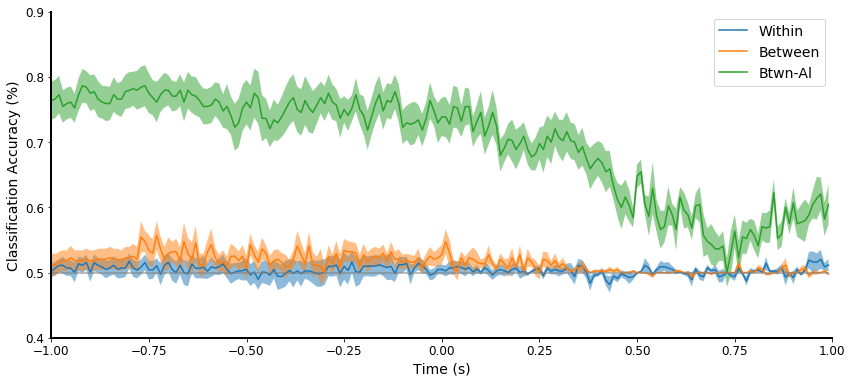

In [129]:
# Set up data for plotting
#results = [avg_time_class_within, avg_time_class_btwn, avg_time_class_btwn_al]
results = [ts_within_scores, ts_btwn_scores, ts_btwn_al_scores]
labels = ['Within', 'Between', 'Btwn-Al']

# 
plot_results(times, results, labels)

In [ ]:
#%matplotlib notebook

import hypertools as hyp

In [ ]:
subj_ind = 2

In [ ]:
#
hyp.plot([np.mean(aligned_data[subj_ind][0:20], 0), np.mean(aligned_data[subj_ind][21:], 0)],
         animate=True, chemtrails=True)

# Single Trial:
#hyp.plot([aligned_data[subj_ind][0, :, :], aligned_data[subj_ind][-1, :, :]], animate=True, title='Aligned')

In [ ]:
hyp.plot([np.mean(all_data[subj_ind][0:20], 0), np.mean(all_data[subj_ind][21:], 0)],
         animate=True)#, chemtrails=True)

# Single Trial:
#hyp.plot([all_data[subj_ind][:, 0:200], all_data[subj_ind][:, -200:]], animate=True, title='Unaligned')

#### CHECKS
Compare hyperaligned to unaligned data

In [ ]:
# Note: these checks are for test cases which use a group of the same data copied over
#print(np.all(all_data[0] == all_data[1]))
#print(np.all(aligned_data[0] == aligned_data[1]))
#print(np.all(aligned_data[0] == all_data[0]))

## Check random rotations

In [ ]:
# Random rotation matrix
#rot = np.random.random(size=n_chs*n_chs).reshape([n_chs, n_chs])

In [ ]:
# Rotation by random matrix
#twod_dat = deepcopy(all_data)
#twod_dat = [np.dot(rot, dat) for dat in twod_dat]
#twod_dat_3d = [make_3d(dat) for dat in twod_dat]

In [ ]:
# Check within subject prediction of random data
#within_rand_scores = within_subj_classification(twod_dat_3d, all_labels)
#print_avg('Within Rand', np.mean(within_rand_scores))

In [ ]:
# Between subject classification
#rand_btwn_scores = btwn_subj_classication(twod_dat_3d, all_labels)

In [ ]:
# Check outcome - average across all subjects
#avg_rand_btwn = np.mean(rand_btwn_scores)
#print_avg('Random Btwn-Subj Prediction', avg_rand_btwn)

## PyMVPA

Apply hyperalignment implementation from the PyMVPA package.

Note: this requires being in a Py2 environment with PyMVPA available.

In [ ]:
from mvpa2.datasets.base import Dataset
from mvpa2.algorithms.hyperalignment import Hyperalignment

In [ ]:
# Re-organize data into PyMVPA datasets objects
datasets = [Dataset(dat.T) for dat in all_data]

In [ ]:
# Run hyperalignment, and get the transformation matrices
hyper_aligner = Hyperalignment(level2_niter=0, zscore_all=False, zscore_common=False)
hyper_aligner.train(datasets)
mappers = hyper_aligner(datasets)

In [ ]:
# Apply the transformations to each dataset, and re-organize data
#   This applies the projection to the 2D data, transpose, and split back into epochs
aligned_datasets = []
for dataset, mapper in zip(datasets, mappers):
    aligned_datasets.append(make_3d(mapper.forward(dataset).samples.T))

In [ ]:
# Check within subject prediction of aligned data
within_al2_scores = within_subj_classification(aligned_datasets, all_labels)
print_avg('Within Al2', np.mean(within_al2_scores))

In [ ]:
# Between subject classification after PyMVPA hyperalignment
btwn_al2_scores = btwn_subj_classication(aligned_datasets, all_labels)

In [ ]:
# Check average performance
avg_btwn_al2 = np.mean(btwn_al2_scores)
print_avg('Aligned-2 Btwn Scores', avg_btwn_al2)

In [ ]:
# 
print_avgs('Between Subj Aligned Data', btwn_al2_scores)

In [ ]:
# Check if the rotation matrices are the same
#np.all(mappers[0].proj == mappers[1].proj)

#### Compare between the two hyperalignment implementations

In [ ]:
# Check the magnitude of differences between aligned data
#diff = aligned_datasets[0] - aligned_data[0]

In [ ]:
#print('Avg Magnitude Diff', np.mean(np.abs(diff)))
#print('Avg Magnitude Data', np.mean(np.abs(aligned_datasets[0])))

In [ ]:
# Check number of overlapping points
#from __future__ import division
#np.sum(np.isclose(aligned_datasets[0], aligned_data[0])) / aligned_data[0].size

## Victory Party.

Soon...